## Описание проекта
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».<br>
- Чтобы скорректировать рекламный бюджет, заказчик хочет понять, какой тариф приносит больше денег.<br>
- Необходимо сделать предварительный анализ тарифов.<br>
- Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Источники данных
* /datasets/calls.csv
* /datasets/internet.csv
* /datasets/messages.csv
* /datasets/tariffs.csv
* /datasets/users.csv

# Описание тарифов
### Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
1. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
1. Стоимость услуг сверх тарифного пакета:

    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»

1. Ежемесячная плата: 1950 рублей
1. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
1. Стоимость услуг сверх тарифного пакета:

    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

## Описание данных


**Таблица users (информация о пользователях):**
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана     

**Таблица calls (информация о звонках):**
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок
* Таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение  

**Таблица internet (информация об интернет-сессиях):**
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя        

**Таблица tariffs (информация о тарифах):**
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

<div style="border:solid #5F9EA0 10px;">

# Проектная часть

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# # будем отображать графики прямо в jupyter'e
# %matplotlib inline
# # #графики в svg выглядят более четкими
# %config InlineBackend.figure_format = 'svg'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import math
from scipy import stats as st

In [3]:
calls = pd.read_csv("/datasets/calls.csv", sep=",")
internet = pd.read_csv("/datasets/internet.csv", sep=",", index_col=0)
messages = pd.read_csv("/datasets/messages.csv", sep=",")
tariffs = pd.read_csv("/datasets/tariffs.csv", sep=",")
users = pd.read_csv("/datasets/users.csv", sep=",")

разделитель ","

Unnamed: 0 надо убрать через отмену указателя индекса *(index_col=0)*

In [4]:
dict_datas=[calls, internet, messages, tariffs, users]
dict_datas_names = {'calls': calls, 'internet': internet, 'messages':messages, 'tariffs': tariffs, 'users': users}
for name in dict_datas_names:
    display(dict_datas_names[name].head())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [5]:
bold_start = '\033[1m'
bold_yellow = '\033[33m'
bold_red = '\033[31m'
bold_violet = '\033[35m'
bold_blue = '\033[34m'
bold_end   = '\033[0m'

for name in dict_datas_names:
    
    print(bold_end+bold_yellow,'{}'.format('Таблица ' + bold_start + name + bold_end + bold_yellow))
    print('\n')
    print(dict_datas_names[name].head())
    print('\n')
    print(bold_end+bold_blue,'{}'.format('Общая информация о таблице ' + bold_start + name + bold_end + bold_blue))
    print('\n')
    dict_datas_names[name].info()    
    print('--------------------------------------------')
    print('\n')

 Таблица calls


       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000


 Общая информация о таблице calls


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
--------------------------------------------


 Таблица internet


       id  mb_used session_date  user_id
0  1000_0   112.95   2018-11-25     1000
1  1000_1  1052.81   2018-09-07     1000
2  1000_2  1197.26   2018-06-25     1000
3  1000_3   550.27   2018-08-22     1000
4  1000_4   302.56   2018-09-24     1000


 Общая информация о таблице internet


<class 'pandas.core.frame.Dat

### Анализ датасеов:

Пропуски отсутсвуют, если не считать **churn_date**, которые обусловлены действием тарифа на момент выгрузки данных

Нужно привести к явным типам следующие столбцы:

|Data    |Column       |Dtype now|Dtype correct|
|--------|-------------|---------|-------------|
|calls   |call_date    |object   |datetime64   |
|internet|session_date |object   |datetime64   |
|messages|message_date |object   |datetime64   |
|users   |reg_date     |object   |datetime64   |

### Чистка:
В таблице Calls есть звонки с продолжительностью **0.0** секунд. Возможно они возникли из-за обрыва связи или отсутствия дозвона. В данном случае факта разговора не было и деньги за неоказание услуги не платили. Если оставить **0.0**, то значения количества звонков будут некорректными.

<div style="border:solid #5F9EA0 10px;">

## Шаг 2. Подготовка данных


### Приведите данные к нужным типам

In [6]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [7]:
for name in dict_datas_names:
    
    print(bold_end+bold_blue,'{}'.format('Общая информация о таблице ' + bold_start + name + bold_end + bold_blue))
    print('\n')
    dict_datas_names[name].info()    
    print('--------------------------------------------')
    print('\n')

 Общая информация о таблице calls


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
--------------------------------------------


 Общая информация о таблице internet


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB
--------------------------------------------


 Общая информация о таблице messages


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (to

### Чистка

Сделаем срез по **duration >0**

In [8]:
calls.shape

(202607, 4)

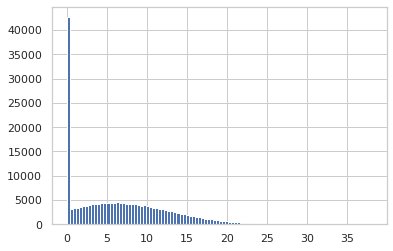

In [9]:
calls['duration'].hist(bins=100)

In [10]:
calls = calls.query('duration >0')

In [11]:
calls.shape

(162994, 4)

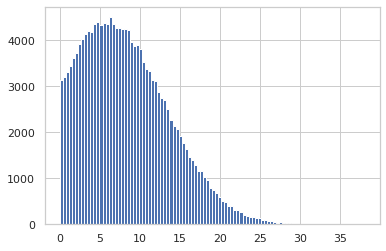

In [12]:
calls['duration'].hist(bins=100)

Обратите внимание: заказчик всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.
Поэтому округлим значения в таблицах

|таблица |столбец |
|--------|--------|
|internet|mb_used |
|calls   |duration|

In [13]:
def rounded_value(row):
    rounded = np.ceil(row)
    return rounded

internet['mb_used'] = internet['mb_used'].apply(rounded_value)
calls['duration'] = calls['duration'].apply(rounded_value)

```python
def rounded_value(row):
    rounded = round(row)
    return rounded
```
Не подходит, используем ceil

Приведем эти стодбцы к формату **int**

In [14]:
internet['mb_used'] = internet.mb_used.astype('int64')
calls['duration'] = calls.duration.astype('int64')

## Посчитаем для каждого пользователя:

- [x] количество сделанных звонков и израсходованных минут разговора по месяцам;
- [x] количество отправленных сообщений по месяцам;
- [x] объем израсходованного интернет-трафика по месяцам;
- [x] помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

добавим столбец с номером месяца

In [15]:
calls['month']= calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month

In [16]:
display(calls)
display(internet)
display(messages)

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,12
202603,1499_216,2018-10-18,19,1499,10
202604,1499_217,2018-11-10,11,1499,11
202605,1499_218,2018-10-06,5,1499,10


,id,mb_used,session_date,user_id,month
0,1000_0,113,2018-11-25,1000,11
1,1000_1,1053,2018-09-07,1000,9
2,1000_2,1198,2018-06-25,1000,6
3,1000_3,551,2018-08-22,1000,8
4,1000_4,303,2018-09-24,1000,9
...,...,...,...,...,...
149391,1499_152,319,2018-10-03,1499,10
149392,1499_153,491,2018-12-14,1499,12
149393,1499_154,0,2018-10-27,1499,10
149394,1499_155,1247,2018-11-26,1499,11


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


### посчитаем с помощью **pivot_table**:
- ##### количество звонков и их длительность по месяцам
- ##### сумарное колличество потраченных мб по месяцам
- ##### количество отправленных смс по месяцам

In [17]:
calls_group = calls.pivot_table(index=['user_id','month'],values='duration',aggfunc = ['sum','count'] )
internet_group = internet.pivot_table(index=['user_id','month'],values='mb_used',aggfunc = ['sum'] )
messages_group = messages.pivot_table(index=['user_id','month'],values='id',aggfunc = ['count'])

In [18]:
calls_group.columns =['sum_min','count_calls']
internet_group.columns= ['sum_mb']
messages_group.columns=['count_messages']

In [19]:
calls_group.reset_index(inplace=True) 
internet_group.reset_index(inplace=True) 
messages_group.reset_index(inplace=True) 

In [20]:
display(calls_group)

display(internet_group)

display(messages_group)

,user_id,month,sum_min,count_calls
0,1000,5,159,17
1,1000,6,172,28
2,1000,7,340,41
3,1000,8,408,42
4,1000,9,466,46
...,...,...,...,...
3163,1498,10,247,30
3164,1499,9,70,8
3165,1499,10,449,44
3166,1499,11,612,62


,user_id,month,sum_mb
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
...,...,...,...
3198,1498,10,20604
3199,1499,9,1848
3200,1499,10,17809
3201,1499,11,17984


,user_id,month,count_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [21]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Объединим таблицы методом **merge**

таблицу **tariffs** можно привязать к **users** через столбец ***tariff***, поэтому переименуем ***'tariff_name': 'tariff'***

In [22]:
tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True)
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [23]:
df = calls_group.merge(internet_group, on=['user_id','month'], how='left')
df = df.merge(messages_group, on=['user_id','month'], how='left')
df = df.merge(users, on=['user_id'], how='left')
df = df.merge(tariffs, on=['tariff'], how='left')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3167
Data columns (total 20 columns):
user_id                  3168 non-null int64
month                    3168 non-null int64
sum_min                  3168 non-null int64
count_calls              3168 non-null int64
sum_mb                   3157 non-null float64
count_messages           2673 non-null float64
age                      3168 non-null int64
churn_date               187 non-null object
city                     3168 non-null object
first_name               3168 non-null object
last_name                3168 non-null object
reg_date                 3168 non-null datetime64[ns]
tariff                   3168 non-null object
messages_included        3168 non-null int64
mb_per_month_included    3168 non-null int64
minutes_included         3168 non-null int64
rub_monthly_fee          3168 non-null int64
rub_per_gb               3168 non-null int64
rub_per_message          3168 non-null int64
rub_per_minute       

Уберем ненужные столбцы и добавим индексацию

In [25]:
df = df.drop(['age', 'churn_date', 'first_name', 'last_name', 'reg_date'],1)

In [26]:
df

,user_id,month,sum_min,count_calls,sum_mb,count_messages,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159,17,2256.0,22.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172,28,23257.0,60.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340,41,14016.0,75.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408,42,14070.0,81.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466,46,14581.0,57.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,1498,10,247,30,20604.0,42.0,Владикавказ,smart,50,15360,500,550,200,3,3
3164,1499,9,70,8,1848.0,11.0,Пермь,smart,50,15360,500,550,200,3,3
3165,1499,10,449,44,17809.0,48.0,Пермь,smart,50,15360,500,550,200,3,3
3166,1499,11,612,62,17984.0,59.0,Пермь,smart,50,15360,500,550,200,3,3


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3167
Data columns (total 15 columns):
user_id                  3168 non-null int64
month                    3168 non-null int64
sum_min                  3168 non-null int64
count_calls              3168 non-null int64
sum_mb                   3157 non-null float64
count_messages           2673 non-null float64
city                     3168 non-null object
tariff                   3168 non-null object
messages_included        3168 non-null int64
mb_per_month_included    3168 non-null int64
minutes_included         3168 non-null int64
rub_monthly_fee          3168 non-null int64
rub_per_gb               3168 non-null int64
rub_per_message          3168 non-null int64
rub_per_minute           3168 non-null int64
dtypes: float64(2), int64(11), object(2)
memory usage: 396.0+ KB


**sum_mb, count_messages** появились пропуски и поэтому поменялся тип данных, исправим это


In [28]:
df.isnull().sum()

user_id                    0
month                      0
sum_min                    0
count_calls                0
sum_mb                    11
count_messages           495
city                       0
tariff                     0
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64

Данные пропуски возникли, потому что пользователь мог не пользоваться смс или интернетом, поэтому заполним их **0**

In [29]:
display(df.query('sum_mb == "NaN"'))
display(df.query('count_messages == "NaN"'))

,user_id,month,sum_min,count_calls,sum_mb,count_messages,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
1693,1273,5,220,19,NaN,21.0,Курган,ultra,1000,30720,3000,1950,150,1,1
1694,1273,6,230,28,NaN,38.0,Курган,ultra,1000,30720,3000,1950,150,1,1
1695,1273,7,253,30,NaN,37.0,Курган,ultra,1000,30720,3000,1950,150,1,1
1696,1273,8,253,39,NaN,41.0,Курган,ultra,1000,30720,3000,1950,150,1,1
1697,1273,9,223,28,NaN,32.0,Курган,ultra,1000,30720,3000,1950,150,1,1
1698,1273,10,315,35,NaN,35.0,Курган,ultra,1000,30720,3000,1950,150,1,1
1699,1273,11,272,31,NaN,29.0,Курган,ultra,1000,30720,3000,1950,150,1,1
1700,1273,12,260,38,NaN,39.0,Курган,ultra,1000,30720,3000,1950,150,1,1
2352,1377,2,179,20,NaN,2.0,Брянск,ultra,1000,30720,3000,1950,150,1,1
2465,1392,2,13,2,NaN,3.0,Челябинск,ultra,1000,30720,3000,1950,150,1,1


,user_id,month,sum_min,count_calls,sum_mb,count_messages,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
8,1001,11,430,45,18452.0,NaN,Москва,smart,50,15360,500,550,200,3,3
9,1001,12,414,47,14053.0,NaN,Москва,smart,50,15360,500,550,200,3,3
42,1006,2,42,3,1395.0,NaN,Ульяновск,smart,50,15360,500,550,200,3,3
43,1006,3,286,36,17309.0,NaN,Ульяновск,smart,50,15360,500,550,200,3,3
44,1006,4,356,38,13954.0,NaN,Ульяновск,smart,50,15360,500,550,200,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,1494,8,262,26,6601.0,NaN,Омск,smart,50,15360,500,550,200,3,3
3136,1494,9,501,57,16986.0,NaN,Омск,smart,50,15360,500,550,200,3,3
3137,1494,10,354,45,17794.0,NaN,Омск,smart,50,15360,500,550,200,3,3
3138,1494,11,411,46,18076.0,NaN,Омск,smart,50,15360,500,550,200,3,3


In [30]:
df = df.fillna(0)
 
internet.mb_used.astype('int64')

df['sum_mb'] = df.sum_mb.astype('int64')
df['count_messages'] = df.count_messages.astype('int64')

In [31]:
display(df.isnull().sum())
display(df.info())

user_id                  0
month                    0
sum_min                  0
count_calls              0
sum_mb                   0
count_messages           0
city                     0
tariff                   0
messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3167
Data columns (total 15 columns):
user_id                  3168 non-null int64
month                    3168 non-null int64
sum_min                  3168 non-null int64
count_calls              3168 non-null int64
sum_mb                   3168 non-null int64
count_messages           3168 non-null int64
city                     3168 non-null object
tariff                   3168 non-null object
messages_included        3168 non-null int64
mb_per_month_included    3168 non-null int64
minutes_included         3168 non-null int64
rub_monthly_fee          3168 non-null int64
rub_per_gb               3168 non-null int64
rub_per_message          3168 non-null int64
rub_per_minute           3168 non-null int64
dtypes: int64(13), object(2)
memory usage: 396.0+ KB


None

---

### Помесячная выручка с каждого пользователя 

Создадим новый столбец с подсчетом остатка возможных услуг 

In [32]:
df['balance_min'] =  df['sum_min'] - df['minutes_included'] 
df['balance_mb'] =  df['sum_mb'] - df['mb_per_month_included']  
df['balance_messages'] =  df['count_messages'] - df['messages_included'] 

In [33]:
df

,user_id,month,sum_min,count_calls,sum_mb,count_messages,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,balance_min,balance_mb,balance_messages
0,1000,5,159,17,2256,22,Краснодар,ultra,1000,30720,3000,1950,150,1,1,-2841,-28464,-978
1,1000,6,172,28,23257,60,Краснодар,ultra,1000,30720,3000,1950,150,1,1,-2828,-7463,-940
2,1000,7,340,41,14016,75,Краснодар,ultra,1000,30720,3000,1950,150,1,1,-2660,-16704,-925
3,1000,8,408,42,14070,81,Краснодар,ultra,1000,30720,3000,1950,150,1,1,-2592,-16650,-919
4,1000,9,466,46,14581,57,Краснодар,ultra,1000,30720,3000,1950,150,1,1,-2534,-16139,-943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,1498,10,247,30,20604,42,Владикавказ,smart,50,15360,500,550,200,3,3,-253,5244,-8
3164,1499,9,70,8,1848,11,Пермь,smart,50,15360,500,550,200,3,3,-430,-13512,-39
3165,1499,10,449,44,17809,48,Пермь,smart,50,15360,500,550,200,3,3,-51,2449,-2
3166,1499,11,612,62,17984,59,Пермь,smart,50,15360,500,550,200,3,3,112,2624,9


Отсеим услуги сверх-тарифа: если значение столбца отрицательное, то пользователь не выходил за рамки тарифа, положительное - берем дополнительную плату

In [34]:
def over_limit(row):
    if row > 0:
        return row
    else:
        return 0
      
df['min_over_limit'] = df['balance_min'].apply(over_limit)
df['mb_over_limit'] = df['balance_mb'].apply(over_limit)
df['messages_over_limit'] = df['balance_messages'].apply(over_limit) 

display(df)

,user_id,month,sum_min,count_calls,sum_mb,count_messages,city,tariff,messages_included,mb_per_month_included,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,balance_min,balance_mb,balance_messages,min_over_limit,mb_over_limit,messages_over_limit
0,1000,5,159,17,2256,22,Краснодар,ultra,1000,30720,...,1950,150,1,1,-2841,-28464,-978,0,0,0
1,1000,6,172,28,23257,60,Краснодар,ultra,1000,30720,...,1950,150,1,1,-2828,-7463,-940,0,0,0
2,1000,7,340,41,14016,75,Краснодар,ultra,1000,30720,...,1950,150,1,1,-2660,-16704,-925,0,0,0
3,1000,8,408,42,14070,81,Краснодар,ultra,1000,30720,...,1950,150,1,1,-2592,-16650,-919,0,0,0
4,1000,9,466,46,14581,57,Краснодар,ultra,1000,30720,...,1950,150,1,1,-2534,-16139,-943,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,1498,10,247,30,20604,42,Владикавказ,smart,50,15360,...,550,200,3,3,-253,5244,-8,0,5244,0
3164,1499,9,70,8,1848,11,Пермь,smart,50,15360,...,550,200,3,3,-430,-13512,-39,0,0,0
3165,1499,10,449,44,17809,48,Пермь,smart,50,15360,...,550,200,3,3,-51,2449,-2,0,2449,0
3166,1499,11,612,62,17984,59,Пермь,smart,50,15360,...,550,200,3,3,112,2624,9,112,2624,9


переведем Mb в Gb и округлим

In [35]:
df['mb_over_limit'] = df['mb_over_limit'] / 1024
df['mb_over_limit'] = df['mb_over_limit'].apply(rounded_value)
df['mb_over_limit'] = df.mb_over_limit.astype('int64')

Посчитаем задолжность + ежемесячная абонентская плата 

In [36]:
df['payment_min_over_limit'] = df['min_over_limit'] * df['rub_per_minute']
df['payment_mb_over_limit'] = df['mb_over_limit'] * df['rub_per_gb']
df['payment_messages_over_limit'] = df['messages_over_limit'] * df['rub_per_message']\

In [37]:
df['total_payment'] = df['payment_min_over_limit'] +df['payment_messages_over_limit'] +df['payment_mb_over_limit'] +df['rub_monthly_fee']

In [38]:
df

,user_id,month,sum_min,count_calls,sum_mb,count_messages,city,tariff,messages_included,mb_per_month_included,...,balance_min,balance_mb,balance_messages,min_over_limit,mb_over_limit,messages_over_limit,payment_min_over_limit,payment_mb_over_limit,payment_messages_over_limit,total_payment
0,1000,5,159,17,2256,22,Краснодар,ultra,1000,30720,...,-2841,-28464,-978,0,0,0,0,0,0,1950
1,1000,6,172,28,23257,60,Краснодар,ultra,1000,30720,...,-2828,-7463,-940,0,0,0,0,0,0,1950
2,1000,7,340,41,14016,75,Краснодар,ultra,1000,30720,...,-2660,-16704,-925,0,0,0,0,0,0,1950
3,1000,8,408,42,14070,81,Краснодар,ultra,1000,30720,...,-2592,-16650,-919,0,0,0,0,0,0,1950
4,1000,9,466,46,14581,57,Краснодар,ultra,1000,30720,...,-2534,-16139,-943,0,0,0,0,0,0,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,1498,10,247,30,20604,42,Владикавказ,smart,50,15360,...,-253,5244,-8,0,6,0,0,1200,0,1750
3164,1499,9,70,8,1848,11,Пермь,smart,50,15360,...,-430,-13512,-39,0,0,0,0,0,0,550
3165,1499,10,449,44,17809,48,Пермь,smart,50,15360,...,-51,2449,-2,0,3,0,0,600,0,1150
3166,1499,11,612,62,17984,59,Пермь,smart,50,15360,...,112,2624,9,112,3,9,336,600,27,1513


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3167
Data columns (total 25 columns):
user_id                        3168 non-null int64
month                          3168 non-null int64
sum_min                        3168 non-null int64
count_calls                    3168 non-null int64
sum_mb                         3168 non-null int64
count_messages                 3168 non-null int64
city                           3168 non-null object
tariff                         3168 non-null object
messages_included              3168 non-null int64
mb_per_month_included          3168 non-null int64
minutes_included               3168 non-null int64
rub_monthly_fee                3168 non-null int64
rub_per_gb                     3168 non-null int64
rub_per_message                3168 non-null int64
rub_per_minute                 3168 non-null int64
balance_min                    3168 non-null int64
balance_mb                     3168 non-null int64
balance_messages        

<div style="border:solid #5F9EA0 10px;">

## Шаг 3. Aнализ данных

- [x] Опишем поведение клиентов оператора.
    - [x] Сколько минут разговора - **'sum_min'**,
    - [x] сколько сообщений **'count_messages'**
    - [x] какой объём интернет-трафика - **'sum_mb'**
    
<br>

- [x] среднее количество 
- [x] дисперсия  
- [x] стандартное отклонение
- [x] гистограммы 
- [x] опишем распределения.

Сделаем отдельные две таблицы по тарифам

In [40]:
ultra = df.query('tariff =="ultra"').copy()
smart = df.query('tariff =="smart"').copy()

In [41]:
ultra_dict_tarif = ultra[{'sum_min', 'count_messages', 'sum_mb', 'total_payment'}]
smart_dict_tarif = smart[{'sum_min', 'count_messages', 'sum_mb', 'total_payment'}]

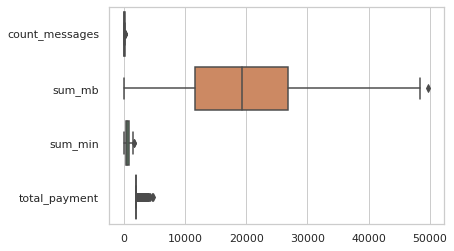

In [42]:
sns.boxplot(data=ultra_dict_tarif, orient="h")

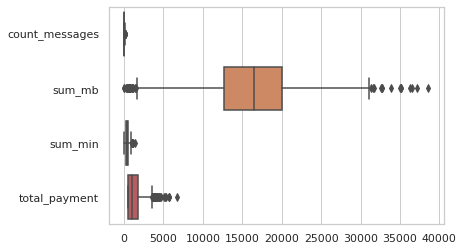

In [43]:
sns.boxplot(data=smart_dict_tarif, orient="h")

Нужные столбцы

In [44]:
dict_tarif = ['sum_min', 'count_messages', 'sum_mb', 'total_payment']

Названия оси x

In [45]:
dict_x_legend = {'sum_min' : 'Min',\
                    'sum_mb':'Mb',\
                    'count_messages': 'Messages',\
                    'total_payment':'Payment'}

Пределы в тарифе smart

In [46]:
dict_limit_smart = {'sum_min' : tariffs['minutes_included'][0],\
                    'sum_mb': tariffs['mb_per_month_included'][0],\
                    'count_messages': tariffs['messages_included'][0],\
                    'total_payment':tariffs['rub_monthly_fee'][0]}

Пределы в тарифе ultra

In [47]:
dict_limit_ultra = {'sum_min' : tariffs['minutes_included'][1],\
                    'sum_mb': tariffs['mb_per_month_included'][1],\
                    'count_messages': tariffs['messages_included'][1],\
                    'total_payment':tariffs['rub_monthly_fee'][1]}

Названия графиков

In [48]:
dict_legend_name_plot = {'sum_min' : 'Min in month',\
                    'sum_mb':'Mb in month',\
                    'count_messages': 'SmS in month',\
                    'total_payment':'Payment in month'}

```python
bold_start = '\033[1m'
bold_yellow = '\033[33m'
bold_red = '\033[31m'
bold_violet = '\033[35m'
bold_blue = '\033[34m'
bold_end   = '\033[0m'
```

```python
range = (0, df['rooms'].quantile(.9)) #масштабирование
```

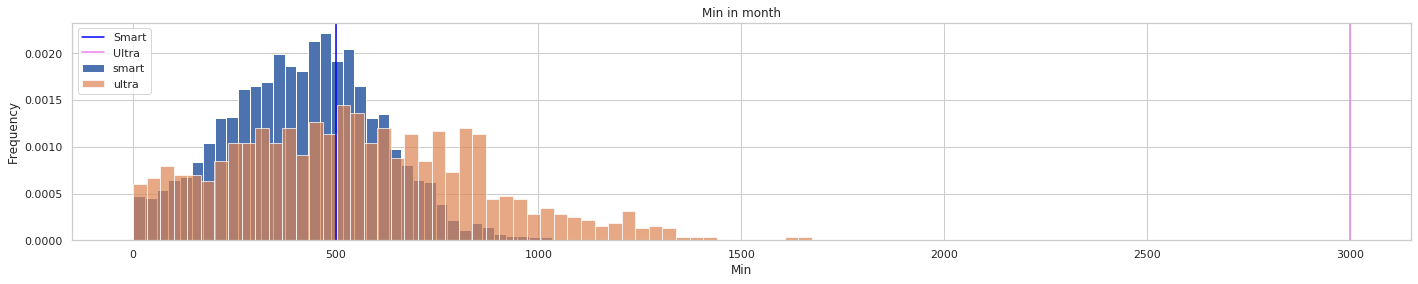

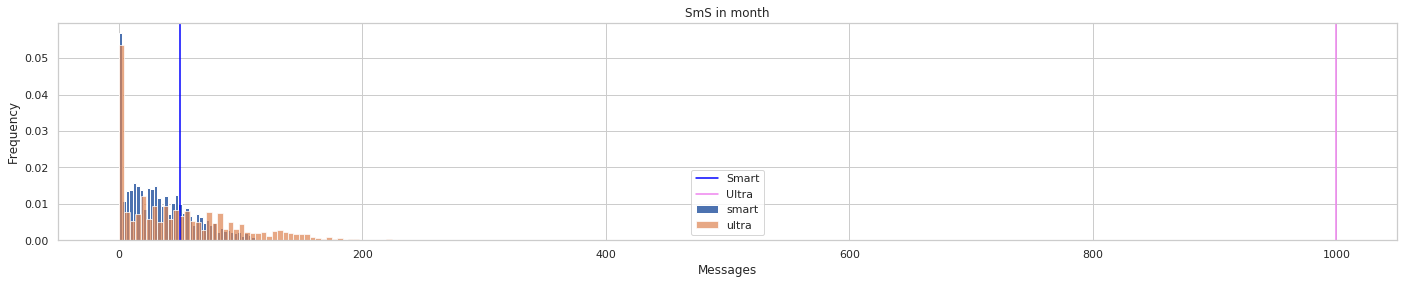

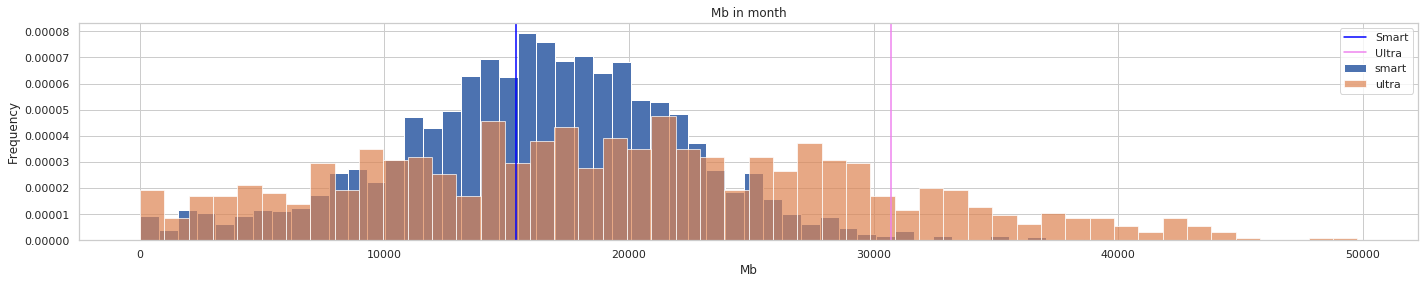

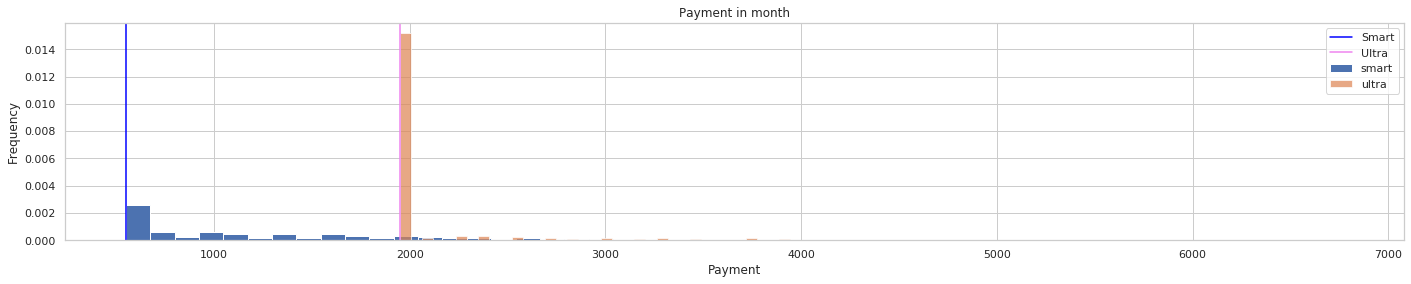

In [49]:
for source in dict_tarif:
    
    smart[source].plot(kind='hist',
                       bins=50,
                       label='smart',
                       density=True,
                       figsize=(24,4),
                       grid=True,
                       title = dict_legend_name_plot[source]) 
    
    ultra[source].plot(kind='hist',
                       bins=50,
                       label='ultra',
                       density=True,
                       figsize=(24,4),
                       alpha=0.7,
                       grid=True)

    plt.xlabel(dict_x_legend[source])
    plt.axvline(x=dict_limit_smart[source], label='Smart', color='blue')
    
    plt.axvline(x=dict_limit_ultra[source], label='Ultra', color='violet')
    plt.legend()
    plt.show()

Smart


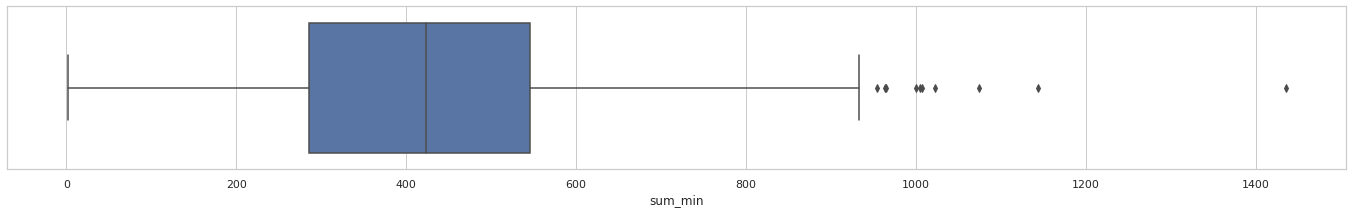

Ultra


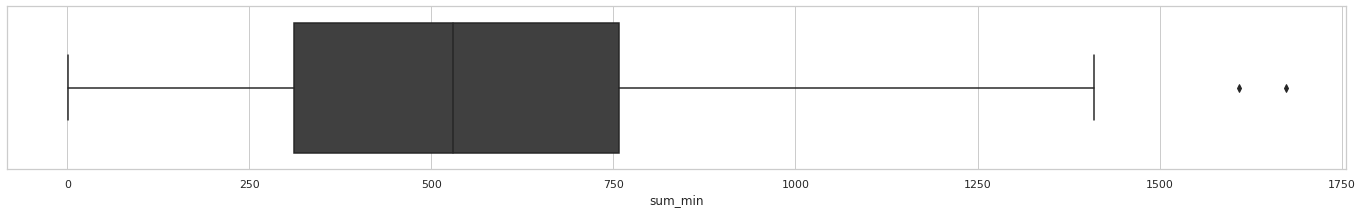

Smart


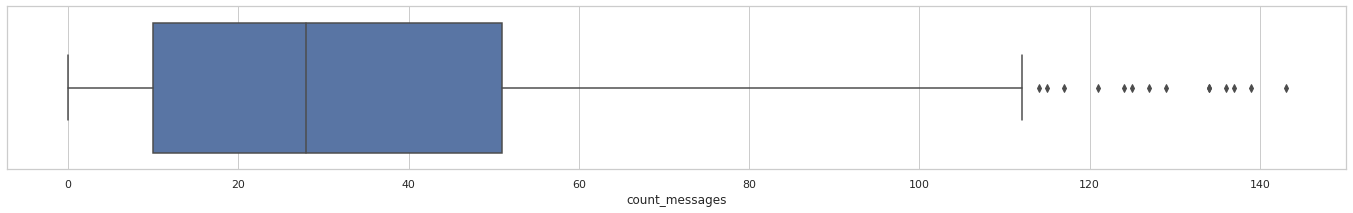

Ultra


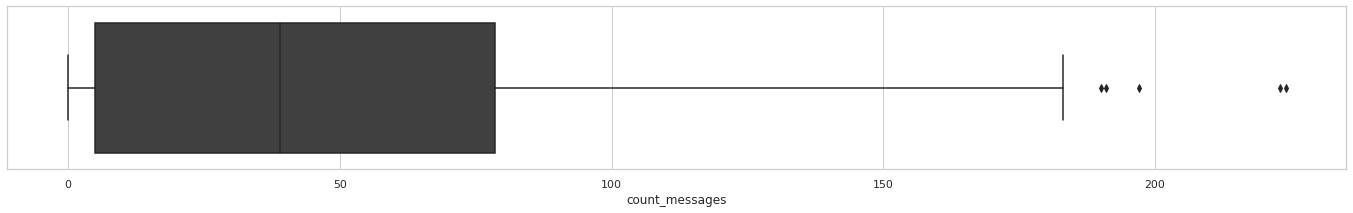

Smart


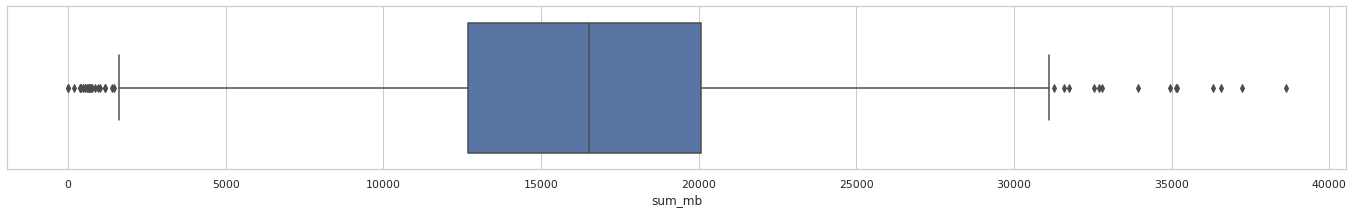

Ultra


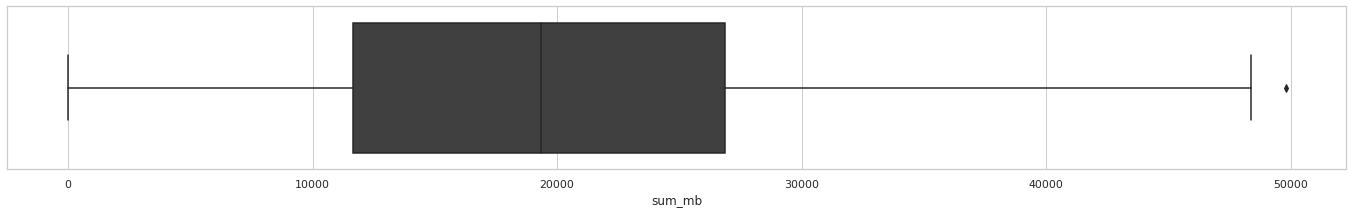

Smart


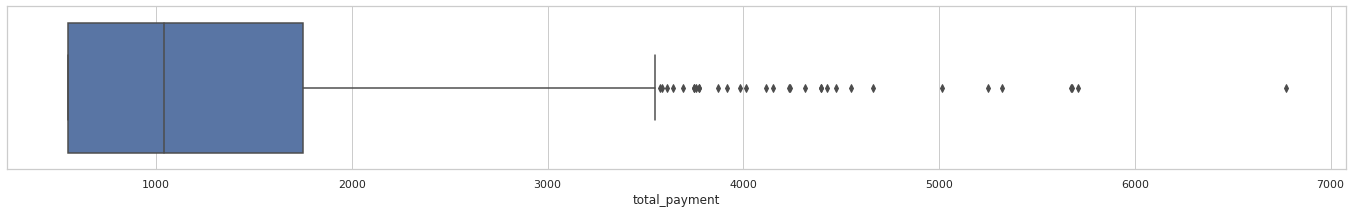

Ultra


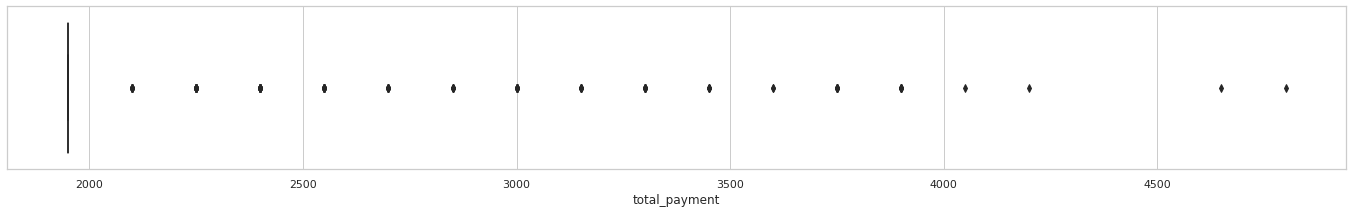

In [50]:
for source in dict_tarif:
    
    print(bold_end + bold_blue + '{}'.format("Smart") + bold_end)
    plt.figure(figsize=(24,3))
    #plt.boxplot(smart[source], vert=False,notch=True, sym="o")
    sns.boxplot(smart[source])
    plt.show()
    
    print(bold_end + bold_violet + '{}'.format("Ultra") + bold_end)
    plt.figure(figsize=(24,3))
    #plt.boxplot(ultra[source], vert=False)
    sns.boxplot(ultra[source],color=".25")
    plt.show()    


In [51]:
def get_statistic_data(df, column_name, tariff_name, describe):
    """Расчет статистичеких даннных для полученного датасета"""
    print(f"\nРасчет значений тарифа \"{tariff_name}\" для столбца \"{column_name}\": ")
    mean = df[column_name].mean()
    variance = np.var(df[column_name])
    standart_dev = np.sqrt(variance)

    print (f"Среднее: {mean:.2f}")
    print (f"Дисперсия: {variance:.2f}")
    print (f"Стандратное отклонение: {standart_dev:.2f}")


In [52]:
def get_statistic_data(df, column_name, tariff_name, describe):
    print(f"\nРасчет значений тарифа \"{tariff_name}\" для столбца \"{column_name}\": ")
    mean = df[column_name].mean()
    variance = np.var(df[column_name])
    standart_dev = np.sqrt(variance)

    print (f"Среднее: {mean:.1f}")
    print (f"Дисперсия: {variance:.1f}")
    print (f"Стандратное отклонение: {standart_dev:.1f}")
    
get_statistic_data(smart, 'sum_min', "Smart", "минут")
get_statistic_data(ultra, 'sum_min', "Ultra", "минут")
get_statistic_data(smart, 'count_messages', "Smart", "сообщений")
get_statistic_data(ultra, 'count_messages', "Ultra", "сообщений")
get_statistic_data(smart, 'sum_mb', "Smart", "MB")
get_statistic_data(ultra, 'sum_mb', "Ultra", "MB")
get_statistic_data(smart, 'total_payment', "Smart", "Рублей")
get_statistic_data(ultra, 'total_payment', "Ultra", "Рублей")  


Расчет значений тарифа "Smart" для столбца "sum_min": 
Среднее: 419.4
Дисперсия: 35702.0
Стандратное отклонение: 188.9

Расчет значений тарифа "Ultra" для столбца "sum_min": 
Среднее: 547.8
Дисперсия: 93239.9
Стандратное отклонение: 305.4

Расчет значений тарифа "Smart" для столбца "count_messages": 
Среднее: 33.4
Дисперсия: 798.8
Стандратное отклонение: 28.3

Расчет значений тарифа "Ultra" для столбца "count_messages": 
Среднее: 48.8
Дисперсия: 2169.4
Стандратное отклонение: 46.6

Расчет значений тарифа "Smart" для столбца "sum_mb": 
Среднее: 16231.5
Дисперсия: 34599364.8
Стандратное отклонение: 5882.1

Расчет значений тарифа "Ultra" для столбца "sum_mb": 
Среднее: 19489.7
Дисперсия: 102650986.3
Стандратное отклонение: 10131.7

Расчет значений тарифа "Smart" для столбца "total_payment": 
Среднее: 1295.8
Дисперсия: 675130.0
Стандратное отклонение: 821.7

Расчет значений тарифа "Ultra" для столбца "total_payment": 
Среднее: 2072.4
Дисперсия: 146405.1
Стандратное отклонение: 382.6


In [53]:
ultra['user_id'].value_counts().index

Int64Index([1453, 1120, 1381, 1385, 1396, 1168, 1375, 1126, 1330, 1292,
            ...
            1304, 1122, 1259, 1084, 1349, 1336, 1485, 1234, 1192, 1397],
           dtype='int64', length=143)

Пользователей ultra: 143 # Не придумал как вытащить это значение, подскажите, пожалуйста

In [54]:
smart['user_id'].value_counts().index

Int64Index([1308, 1472, 1496, 1429, 1394, 1219, 1423, 1227, 1340, 1238,
            ...
            1129, 1117, 1223, 1103, 1170, 1297, 1095, 1194, 1190, 1141],
           dtype='int64', length=349)

smart: 349

In [55]:
print('средняя выручка абонентов Ultra', ultra['total_payment'].mean())
print('число абонентов Ultra в датасете = 143')
print('абонентская плата Ultra:', tariffs['rub_monthly_fee'][1])
print('средняя выручка абонентов Smart', smart['total_payment'].mean())
print('число абонентов Smart в датасете = 349')
print('абонентская плата Smart:', tariffs['rub_monthly_fee'][0])

средняя выручка абонентов Ultra 2072.4392819429777
число абонентов Ultra в датасете = 143
абонентская плата Ultra: 1950
средняя выручка абонентов Smart 1295.790634849167
число абонентов Smart в датасете = 349
абонентская плата Smart: 550


## Вывод:
Пользователи тарифом **Ultra** больше времени тратят на звонки и больше сидять в интернете, но чуть меньше пишут СМС, чем пользователи тарифа **Smart**

Большая часть пользователей **Ultra** не выходят за рамки тарифа. Что нельзя сказать о пользователях **Smart**, чаще они переплачивают в два раза. Минут и интернета в обоих случаях часто не хватает, что говорит о необходимости переработки тарифов или создании нового.

При этом пользователей тарифом **Smart** почти в два с половиной раза больше

<div style="border:solid #5F9EA0 10px;">

## Шаг 4. Проверка гипотез

- [x] средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- [x] средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Гипотеза 1:
- нулевая гипотеза: Средняя выручка пользователей тарифов «Ультра» и «Смарт» **одинакова**
- альтернативная гипотеза: Средняя выручка пользователей тарифов «Ультра» и «Смарт» **различается**

In [56]:
alpha_tarif = 0.05

results_tarif = st.ttest_ind(
    ultra['total_payment'], 
    smart['total_payment'])

print('p-значение:', results_tarif.pvalue)

if (results_tarif.pvalue < alpha_tarif):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.399451579946976e-152
Отвергаем нулевую гипотезу


#### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается !

Гипотеза 2:
- нулевая гипотеза: Средняя выручка пользователей из Москвы **не отличается** от выручки пользователей из других регионов
- альтернативная гипотеза: Средняя выручка пользователей из Москвы **отличается** от выручки пользователей из других регионов

In [57]:
users_moscow = df.query('city == "Москва"').copy()
users_other = df.query('city != "Москва"').copy()

In [58]:
alpha_cities = 0.01

results_cities = st.ttest_ind(
    users_moscow['total_payment'], 
    users_other['total_payment'])

print('p-значение:', results_cities.pvalue)

if (results_cities.pvalue < alpha_cities):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу" )

p-значение: 0.44703780668956883
Не получилось отвергнуть нулевую гипотезу


In [59]:
print('средняя выручка абонентов из Москвы: {:.2f}'.format(users_moscow['total_payment'].mean()))
print('средняя выручка абонентов из других регионов: {:.2f}'.format(users_other['total_payment'].mean()))

средняя выручка абонентов из Москвы: 1550.15
средняя выручка абонентов из других регионов: 1522.66


#### Средняя выручка пользователей из Москвы **не отличается** от выручки пользователей из других регионов !

<div style="border:solid #5F9EA0 10px;">

### Общий вывод
- Для части пользователей тарифа Smart можно сделать предложения по переходу на другой тариф или тот же самый Ultra, чтобы не сбежали
- Абоненты Ultra приносят больше денег приблизительно в 2 раза, но количество абонентов в 2,5 раза меньше